In [1]:

import zipfile
import datetime
from collections import Counter
import cv2
import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.utils import plot_model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import cv2
import os
import time
import shutil
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import keras 
from keras.models import Sequential, Model
from tensorflow.keras import layers
from keras.applications import VGG16
from keras.applications import DenseNet121
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg
from keras.applications.densenet import preprocess_input as preprocess_input_densenet
from keras.layers.experimental.preprocessing import Rescaling
from keras.layers import Input, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
import pickle

# Image Directory

In [2]:
img_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/'

In [3]:
covid_image=cv2.imread('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/COVID-1.png')      
Normal_image=cv2.imread('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-1.png')
pneumonia_image=cv2.imread('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-1.png')  
Lung_image=cv2.imread('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/Lung_Opacity-1.png')  


# Showing All Class type of Image

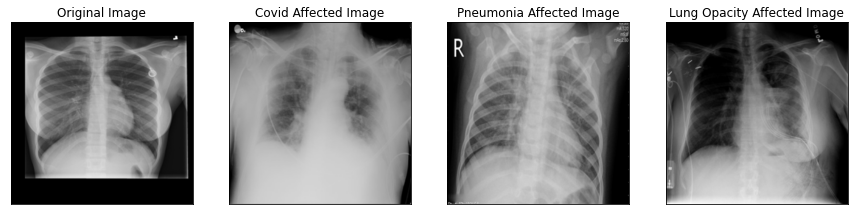

In [4]:
titles = ['Original Image', 
            'Covid Affected Image', 'Pneumonia Affected Image', 'Lung Opacity Affected Image']
images = [Normal_image,covid_image, pneumonia_image,Lung_image]

plt.figure(figsize=(15,7))
for i in range(0,4):
    plt.subplot(1,4,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

# Data Set Appending

In [5]:
list_files = []
for dir in os.listdir(img_path):
  aux_dir = os.path.join(img_path,dir)
  
  if os.path.isdir(aux_dir):
    for img in os.listdir(aux_dir):
      #img = my_preprocessing_function(img)
      list_files.append([os.path.join(dir,img),dir])
df = pd.DataFrame(list_files, columns=['id','label'])
df.describe()

,id,label
count,21165,21165
unique,21165,4
top,Normal/Normal-8619.png,Normal
freq,1,10192


# Frequency Ploting Of DataSet

In [6]:
from collections import Counter
def frequency_plot(df):
  freq_abs = Counter(df.label);
  freq_a = pd.DataFrame.from_dict(freq_abs, orient='index').reset_index()
  total = len(df.index)
  freq_r = freq_a[0]/total
  freq_a[1] = freq_r
  freq_a.columns = ['Label','Frequência absoluta','Frequência relativa']
  return freq_a
frequency_plot(df)

,Label,Frequência absoluta,Frequência relativa
0,Normal,10192,0.481550
1,Lung_Opacity,6012,0.284054
2,Viral Pneumonia,1345,0.063548
3,COVID,3616,0.170848


# DataSet Balancing

In [7]:
def balance_dataset(focus_class, df):
  classes = df.label.unique()
  classes_df_list = []
  focus_class_df = df[df.label == focus_class]
  classes_df_list.append(focus_class_df)
  count_focus_class = len(focus_class_df)
  ##Divide by class
  for classe in classes:
    class_df = df[df.label == classe]
    count_class = len(class_df)
    if classe == focus_class:
      continue
    if count_class > count_focus_class:
      class_df = class_df.sample(count_focus_class)
    classes_df_list.append(class_df)
  df_under = pd.concat(classes_df_list, axis=0) 
  return df_under


df = balance_dataset('COVID',df)

frequency_plot(df)

,Label,Frequência absoluta,Frequência relativa
0,COVID,3616,0.296564
1,Normal,3616,0.296564
2,Lung_Opacity,3616,0.296564
3,Viral Pneumonia,1345,0.110309


#  Test,Validation, Training Spliting

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
def split_dataset(df,test_size,random_state = 101):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
  df = df.reset_index()
  for train_index, test_index in sss.split(df['id'], df['label']):
    X_train, X_test = df['id'][train_index], df['id'][test_index]
    y_train, y_test = df['label'][train_index], df['label'][test_index]
  traindf = pd.concat([X_train, y_train], axis=1)
  testdf = pd.concat([X_test, y_test], axis=1)
  return traindf,testdf

#divide train/val/test in 80/10/10
traindf,testdf = split_dataset(df,test_size = 0.25)
valdf,testdf= split_dataset(testdf,test_size = 0.50)
# traindf = balance_dataset('COVID',df)


traindf.id = img_path + traindf.id
valdf.id = img_path + valdf.id
testdf.id = img_path + testdf.id

# Input Shape

In [9]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)

# Data Generator

In [10]:

train_datagen = ImageDataGenerator(rescale=1./255,shear_range = 0.1,rotation_range=0.05)
test_datagen = ImageDataGenerator(rescale=1./255)
print("Creating train generator...")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="COVID-19_Radiography_Dataset",
    x_col="id",
    y_col="label",
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=5,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory="COVID-19_Radiography_Dataset",
    x_col="id",
    y_col="label",
    color_mode="rgb",
    seed=5,
    shuffle = False,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)
print("\nCreating val generator...")
val_generator = val_datagen.flow_from_dataframe(
    dataframe=valdf,
    directory="COVID-19_Radiography_Dataset",
    x_col="id",
    y_col="label",
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=5,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)

Creating train generator...
Found 9144 validated image filenames belonging to 4 classes.
Found 1525 validated image filenames belonging to 4 classes.

Creating val generator...
Found 1524 validated image filenames belonging to 4 classes.


# Load MobileNetV2

In [11]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = True

9412608/9406464 [==============================] - 0s 0us/step


# Tune MobileNetV2

In [12]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [13]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# Add Layer

In [14]:
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.60))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.60))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.30))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.30))
model.add(layers.Dense(4, activation='softmax',name="fc_out"))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              64226304  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               5

# Checkpoint

In [15]:
checkpoints_path = '/kaggle/output/models_checkpoints/covid_project'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoints_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
#to avoid overfitting
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=7)
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

# Fit Model

In [16]:
EPOCHS = 200
LEARNING_RATE = 1e-6
DECAY= LEARNING_RATE/EPOCHS
model.compile(
    loss='categorical_crossentropy',
    # optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
     optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE),
    metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),
             'acc']
)

callbacks = [model_checkpoint_callback,early,mcp_save]
history2 = model.fit_generator(
    train_generator,
    steps_per_epoch =len( train_generator),
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data = val_generator,
    validation_steps=len(val_generator),
    verbose=1
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
286/286 [==============================] - 188s 629ms/step - loss: 3.9016 - recall: 0.1446 - precision: 0.1575 - acc: 0.1643 - val_loss: 1.3118 - val_recall: 0.0289 - val_precision: 0.3284 - val_acc: 0.3406
Epoch 2/200
286/286 [==============================] - 143s 500ms/step - loss: 2.2303 - recall: 0.1855 - precision: 0.2462 - acc: 0.2469 - val_loss: 1.2513 - val_recall: 0.0374 - val_precision: 0.5377 - val_acc: 0.4259
Epoch 3/200
286/286 [==============================] - 143s 500ms/step - loss: 1.9103 - recall: 0.2106 - precision: 0.3042 - acc: 0.2912 - val_loss: 1.1949 - val_recall: 0.0531 - val_precision: 0.7364 - val_acc: 0.4869
Epoch 4/200
286/286 [==============================] - 144s 503ms/step - loss: 1.7405 - recall: 0.2254 - precision: 0.3428 - acc: 0.3246 - val_loss: 1.1408 - val_recall: 0.0906 - val_precision: 0.8466 - val_acc: 0.5394
Epoch 5/200
286/286 [==============================] - 143s 501ms/step - loss: 1.6232 - recall: 0.2310 - precision: 0.3694 -

# Loss Curve And Accuracy Curve

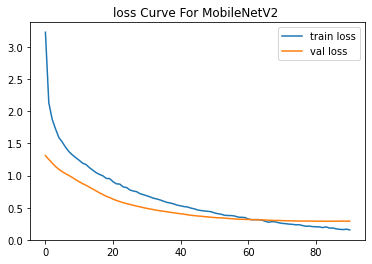

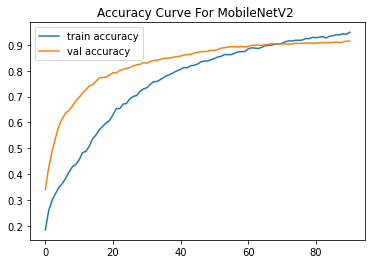

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
model.save("my_model_ImageNet.h5")
plt.title("loss Curve For MobileNetV2 ")
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(history2.history['acc'], label='train accuracy')
plt.plot(history2.history['val_acc'], label='val accuracy')
plt.title("Accuracy Curve For MobileNetV2 ")
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Testing

In [18]:
model.evaluate(test_generator)

48/48 [==============================] - 16s 346ms/step - loss: 0.3118 - recall: 0.9003 - precision: 0.9166 - acc: 0.9062


[0.3117525279521942,
 0.9003278613090515,
 0.9165554046630859,
 0.9062294960021973]

# Accuracy Measurement

In [19]:
from sklearn.metrics import classification_report

test_pred_raw = model.predict(test_generator)
test_labels = np.asarray(test_generator.classes)
test_pred = np.argmax(test_pred_raw, axis=1)

class_names = list(test_generator.class_indices.keys())
print(classification_report(test_labels, test_pred))
print(test_generator.class_indices)

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       452
           1       0.89      0.88      0.89       452
           2       0.87      0.88      0.88       452
           3       0.96      0.96      0.96       169

    accuracy                           0.91      1525
   macro avg       0.91      0.92      0.91      1525
weighted avg       0.91      0.91      0.91      1525

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


# Confution Matrix

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix for ImageNetV2',
                          cmap=None,
                          normalize=True):
    


    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
      cm = cm / np.expand_dims(cm.sum(axis=1),axis=1)
        # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      pass

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

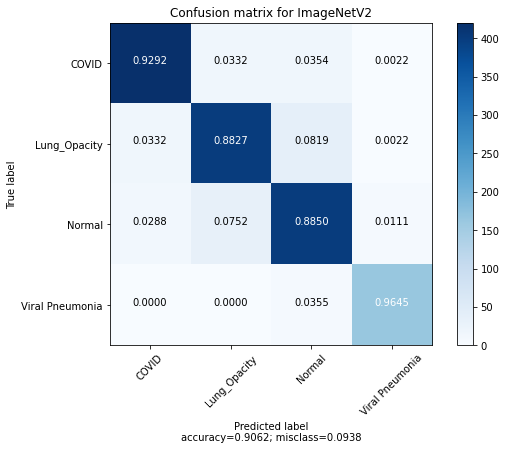

In [21]:
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
plot_confusion_matrix(cm,class_names)